# `10-create-figure-4`

In [1]:
import numpy, pandas, pathlib

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib_venn import venn3

import seaborn

import xgboost

from skops.io import load

pandas.options.display.max_columns = 999

pathlib.Path('pdf/figure-4').mkdir(exist_ok=True)

### Setup

First let's load the trained models, the Test dataset and performance of the models on the Test dataset which was calculated and written to disc by the last notebook

In [2]:
best_model = {}

for model in ['LR', 'NN', 'XB']:
    best_model[model] = load('models/'+model.lower()+'.skops', trusted=True)

# load the test dataset
X={}
Y={}
Z={}
X['test']={}
Y['test']={}
Z['test']={}
with open('data/ds-test.npy', 'rb') as f:
    Y['test']['input'] = numpy.load(f)
    X['test']['input'] = numpy.load(f)
    Z['test']['input'] = numpy.load(f, allow_pickle=True)

# load the results for the test dataset
results = pandas.read_csv('results-test.csv')
results

,model,dataset,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,roc_auc_mean,roc_auc_std,TN,FP,FN,TP,model_parameters,diagnostic_odds_ratio_mean,diagnostic_odds_ratio_std
0,LR,test,79.611650,NaN,72.164948,NaN,82.784506,NaN,70.0,27.0,21.0,82.0,NaN,10.123457,0
1,NN,test,75.728155,NaN,58.762887,NaN,75.097588,NaN,57.0,40.0,25.0,78.0,NaN,4.446000,0
2,XB,test,92.233010,NaN,35.051546,NaN,80.462416,NaN,34.0,63.0,8.0,95.0,NaN,6.408730,0
3,LR,test_0,81.372549,NaN,71.428571,NaN,83.693477,NaN,70.0,28.0,19.0,83.0,NaN,10.921053,0
4,LR,test_1,84.693878,NaN,66.666667,NaN,83.153261,NaN,68.0,34.0,15.0,83.0,NaN,11.066667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,XB,test_98,91.346154,NaN,33.333333,NaN,75.866386,NaN,32.0,64.0,9.0,95.0,NaN,5.277778,0
302,XB,test_99,94.736842,NaN,38.095238,NaN,83.468672,NaN,40.0,65.0,5.0,90.0,NaN,11.076923,0
303,LR,bootstrapped,79.788435,0.760240,72.123166,0.830866,82.583369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
304,NN,bootstrapped,75.798403,0.794033,58.923656,0.951593,75.063257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [3]:
errors = {}
errors['vme'] = {}
errors['me'] = {}
correct = {}
correct['R'] = {}
correct['S'] = {}

for model in ['LR', 'NN', 'XB']:

    y_predicted = best_model[model].predict(X['test']['input'])

    errors['vme'][model] = set(Z['test']['input'][(Y['test']['input']==1) & (y_predicted==0)])
    
    errors['me'][model] = set(Z['test']['input'][(Y['test']['input']==0) & (y_predicted==1)])

    correct['R'][model] = set(Z['test']['input'][(Y['test']['input']==1) & (y_predicted==1)])

    correct['S'][model] = set(Z['test']['input'][(Y['test']['input']==0) & (y_predicted==0)])

    print(model, '| very major errors =', len(errors['vme'][model]), '| major errors =', len(errors['me'][model]))

LR | very major errors = 21 | major errors = 27
NN | very major errors = 25 | major errors = 40
XB | very major errors = 8 | major errors = 63


In [4]:
i='vme'
fig = plt.figure(figsize=(4,4))
axes = venn3([errors[i]['LR'], errors[i]['NN'], errors[i]['XB']], set_labels=['LR','NN','XB'], set_colors=('#800026','#fd8d3c','#ffeda0'))
axes.get_patch_by_id('111').set_color('#fd8455')
axes.get_patch_by_id('111').set_alpha(0.8)
fig.savefig('pdf/figure-4/fig-4-venn-'+i+'.pdf',bbox_inches='tight',transparent=False)
plt.close()

i='me'
fig = plt.figure(figsize=(4,4))
axes = venn3([errors[i]['LR'], errors[i]['NN'], errors[i]['XB']], set_labels=['LR','NN','XB'], set_colors=('#045a8d','#3690c0','#d0d1e6'))
axes.get_patch_by_id('111').set_color('#5099be')
axes.get_patch_by_id('111').set_alpha(0.8)
fig.savefig('pdf/figure-4/fig-4-venn-'+i+'.pdf',bbox_inches='tight',transparent=False)
plt.close()


In [5]:
very_major_errors = errors['vme']['NN'].intersection(errors['vme']['LR'].intersection(errors['vme']['XB']))
major_errors = errors['me']['NN'].intersection(errors['me']['LR'].intersection(errors['me']['XB']))
correct_R = correct['R']['NN'].intersection(correct['R']['LR'].intersection(correct['R']['XB']))
correct_S = correct['S']['NN'].intersection(correct['S']['LR'].intersection(correct['S']['XB']))

In [6]:
foo = sorted([int(i[1:-1]) for i in very_major_errors])
'resid '+' '.join(str(i) for i in foo)

'resid 38 88 93 112 118 149'

In [7]:
foo = sorted([int(i[1:-1]) for i in major_errors])
'resid '+' '.join(str(i) for i in foo)

'resid 11 17 17 19 21 23 28 35 45 45 46 58 59 79 79 143 144 161 163 178'

Now load back the dataset with the features and label so we can analyse which features led to the discrepancies

In [8]:
df = pandas.read_csv('data/ds-traintest-phen-features.csv')
df.loc[df.mutation.isin(very_major_errors), 'label'] = 'vme'
df.loc[df.mutation.isin(major_errors), 'label'] = 'me'
df.loc[df.mutation.isin(correct_R), 'label'] = 'R'
df.loc[df.mutation.isin(correct_S), 'label'] = 'S'

df.label.value_counts()

label
nan    537
R       73
S       28
me      20
vme      6
Name: count, dtype: int64

In [9]:
df[:3]

,mutation,segid,phenotype,d_volume,d_hydropathy_KD,d_Pi,d_MW,d_rogov,phi,psi,residue_sasa,n_hbond_acceptors,n_hbond_donors,secondary_structure_codes,temp_factor,depth,deep_ddG,rasp_score_ml,snap2_score,dist_FE2,dist_PZA,mcsm_stability_ddG,mapp_score,label
0,M1L,A,R,3.8,1.9,0.24,-18.0,-0.389,0.0,-35.2,86.2,2.0,0.0,4,59.720001,2.103049,-0.770,-0.107405,20,29.948318,27.641663,-0.771,13.49,nan
1,M1T,A,R,-46.8,-2.6,-0.14,-30.1,-0.548,0.0,-35.2,86.2,2.0,0.0,4,59.720001,2.103049,-1.096,0.655765,52,29.948318,27.641663,-0.367,25.97,nan
2,M1V,A,S,-22.9,2.3,0.22,-32.1,-0.514,0.0,-35.2,86.2,2.0,0.0,4,59.720001,2.103049,-0.908,0.364061,4,29.948318,27.641663,-0.912,30.01,nan


/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_85629/3182878064.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='deep_ddG', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_85629/3182878064.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='mapp_score', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_85629/3182878064.py:22: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='residue_sasa', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_

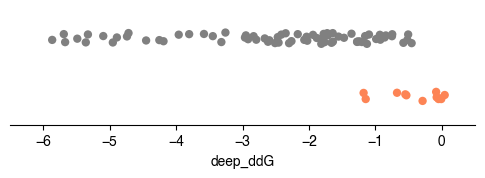

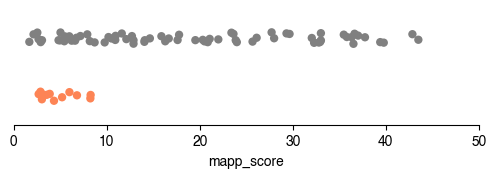

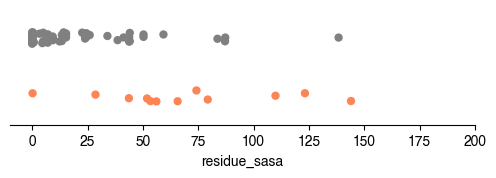

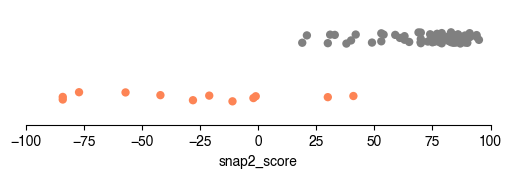

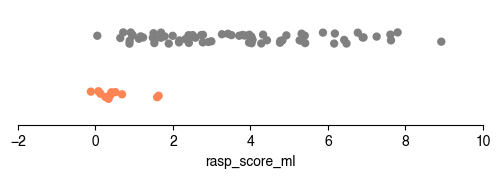

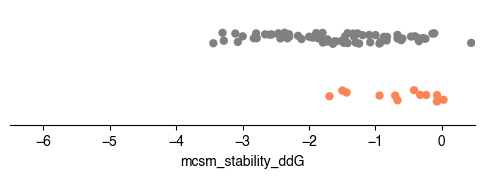

In [69]:
fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='deep_ddG', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
axes.set_xlim([-6.5,0.5])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-vme-deepDDG.pdf', bbox_inches='tight', transparent=True)


fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='mapp_score', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
axes.set_xlim([0,50])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-vme-mapp.pdf', bbox_inches='tight', transparent=True)


fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='residue_sasa', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
axes.set_xlim([-10,200])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-vme-sasa.pdf', bbox_inches='tight', transparent=True)

fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='snap2_score', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
axes.set_xlim([-100,100])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-vme-snap2.pdf', bbox_inches='tight', transparent=True)

fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='rasp_score_ml', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
axes.set_xlim([-2,10])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-vme-rasp.pdf', bbox_inches='tight', transparent=True)

fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['vme','R'])], x='mcsm_stability_ddG', y='label', order = ['R','vme'], size=6, palette={'vme':'#fd8455', 'R':'grey'})
axes.set_xlim([-6.5,0.5])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-vme-mcsm_ddG.pdf', bbox_inches='tight', transparent=True)

/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_85629/342588029.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='deep_ddG', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_85629/342588029.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='rasp_score_ml', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_85629/342588029.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='mcsm_stability_ddG', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_856

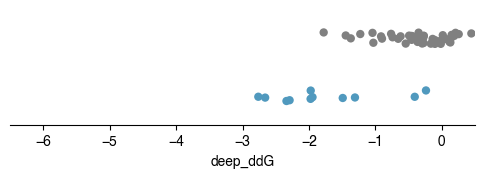

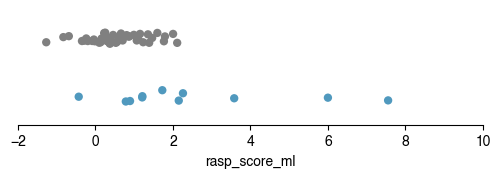

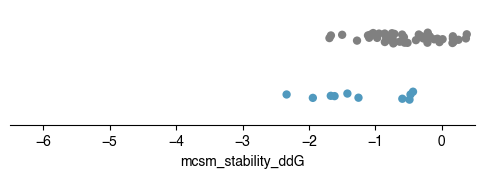

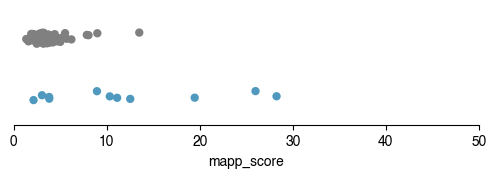

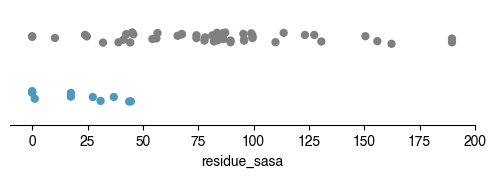

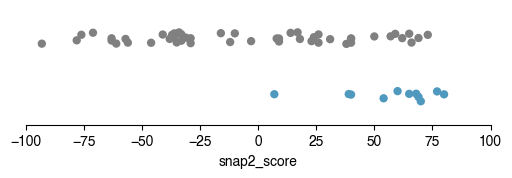

In [67]:
fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='deep_ddG', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
axes.set_xlim([-6.5,0.5])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-me-deepDDG.pdf', bbox_inches='tight', transparent=True)

fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='rasp_score_ml', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
axes.set_xlim([-2,10])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-me-rasp.pdf', bbox_inches='tight', transparent=True)

fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='mcsm_stability_ddG', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
axes.set_xlim([-6.5,0.5])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-me-mcsm_ddG.pdf', bbox_inches='tight', transparent=True)


fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='mapp_score', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
axes.set_xlim([0,50])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-me-mapp.pdf', bbox_inches='tight', transparent=True)


fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='residue_sasa', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
axes.set_xlim([-10,200])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-me-sasa.pdf', bbox_inches='tight', transparent=True)

fig,axes=plt.subplots(1,1,figsize=(6,1.5))
axes = seaborn.stripplot(data=df[df.label.isin(['me','S'])], x='snap2_score', y='label', order = ['S','me'], size=6, palette={'me':'#5099be', 'S':'grey'})
axes.set_xlim([-100,100])
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('pdf/figure-4/fig-4-discrepancy-me-snap2.pdf', bbox_inches='tight', transparent=True)

First let's retrieve the names of the features and label the features in the XGBoost model

In [53]:
df = pandas.read_csv('data/ds-traintest-phen-features.csv')
df.drop(columns=['secondary_structure_codes',
 'd_MW',
 'phi',
 'd_volume',
 'd_Pi',
 'n_hbond_acceptors'],inplace=True)
features = df.iloc[:,3:]
numerical_attribs = list(features)
best_model['XB'].get_booster().feature_names = numerical_attribs

Now let's plot the feature importances of the XGBoost model

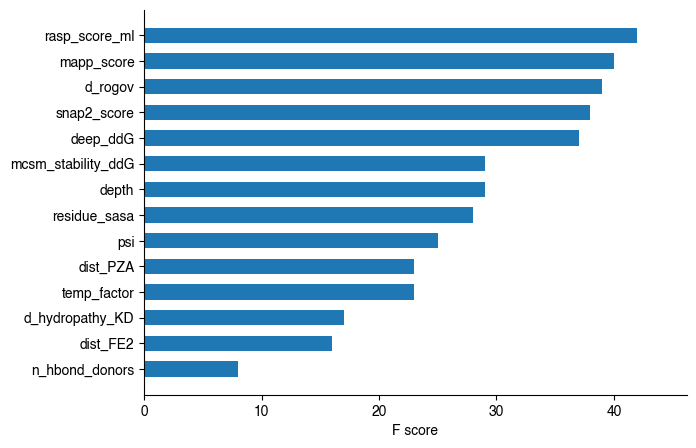

In [54]:
fig,axes=plt.subplots(1,1,figsize=(7,5))
axes = xgboost.plot_importance(best_model['XB'], show_values=False, height=0.6, ylabel=None, grid=False, title=None, ax=axes)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
fig.savefig('pdf/figure-4/si-xgboost-importance.pdf',bbox_inches='tight', transparent=True)

We can also plot trees from the XGBoost model

In [13]:
# image = xgboost.to_graphviz(best_model['XB'])
# image.graph_attr = {'dpi':'400'}
# image.render('foo', format='png')

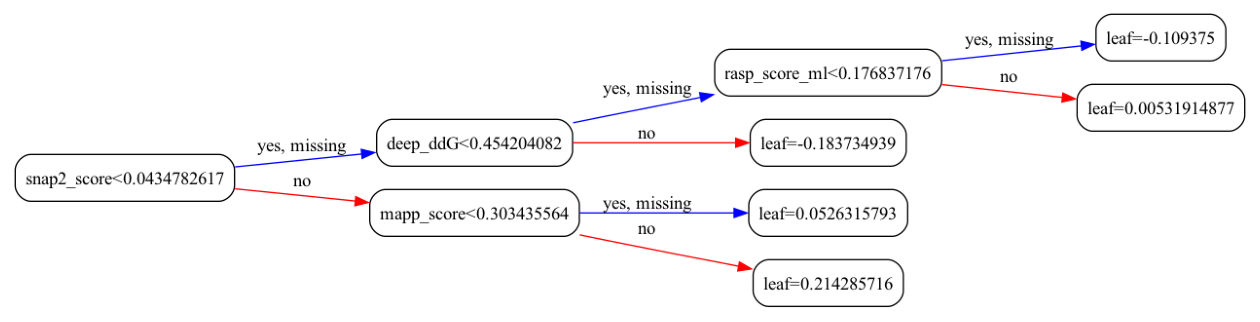

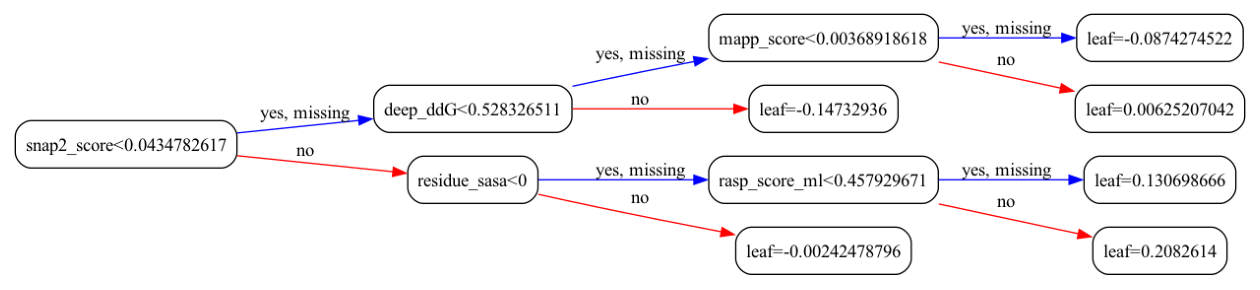

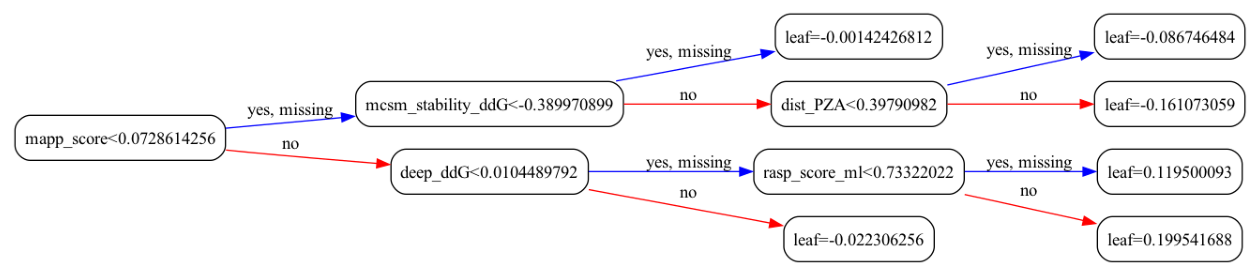

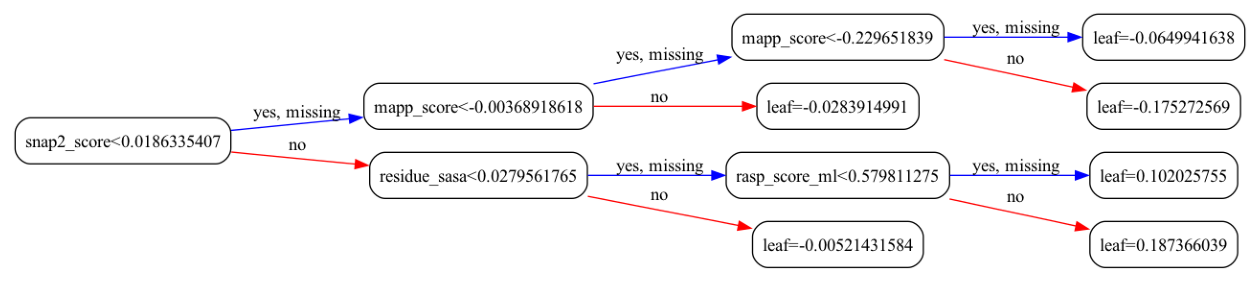

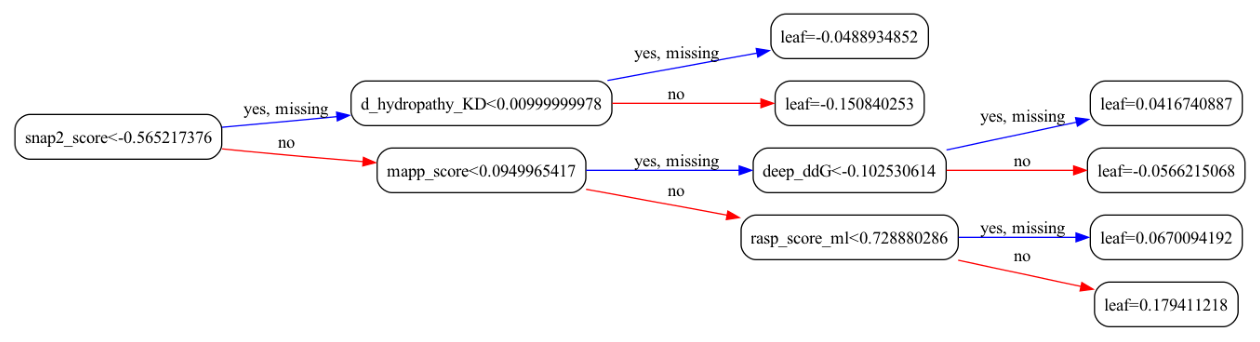

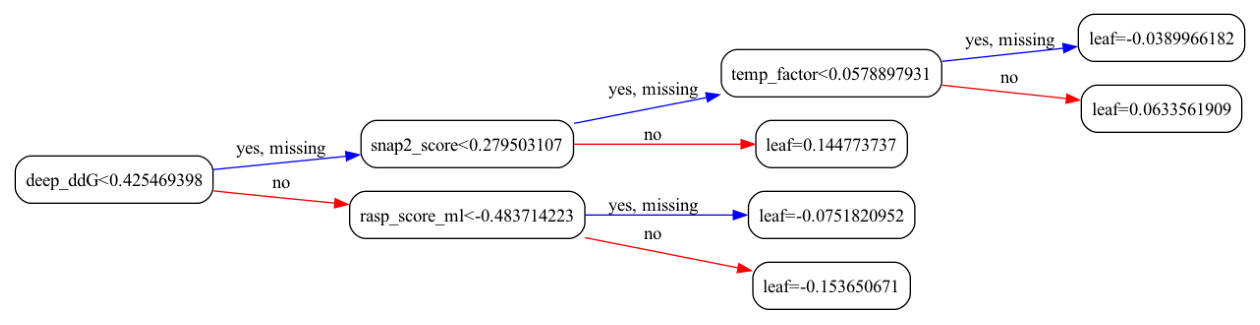

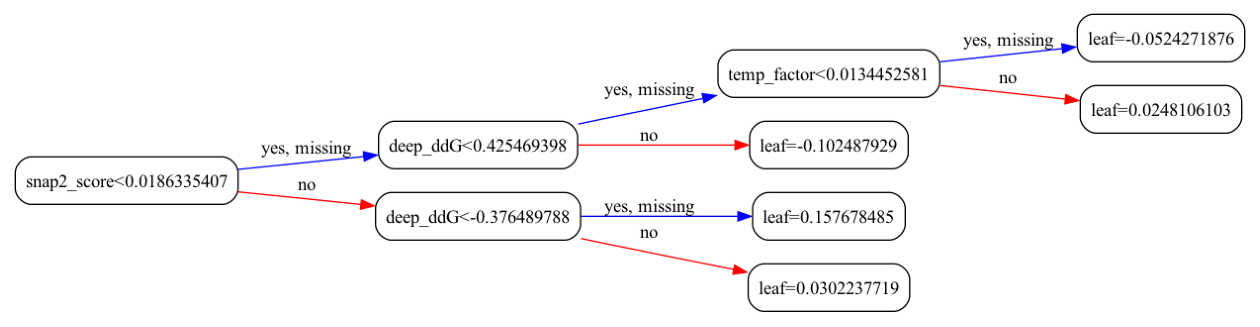

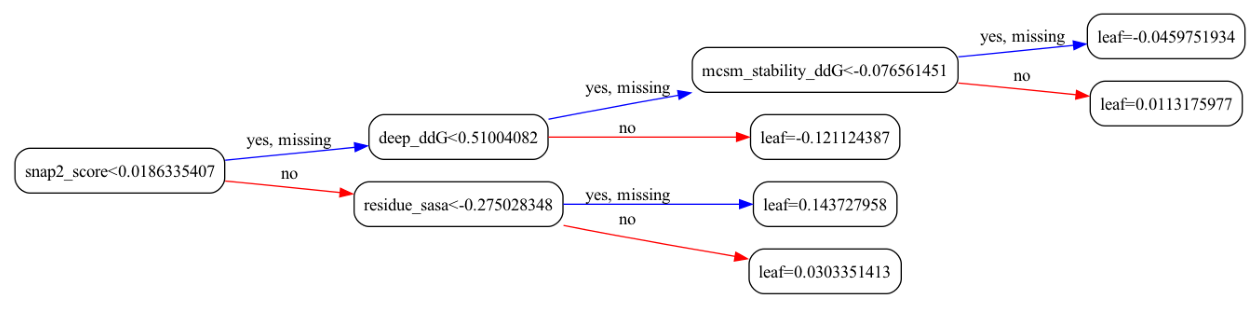

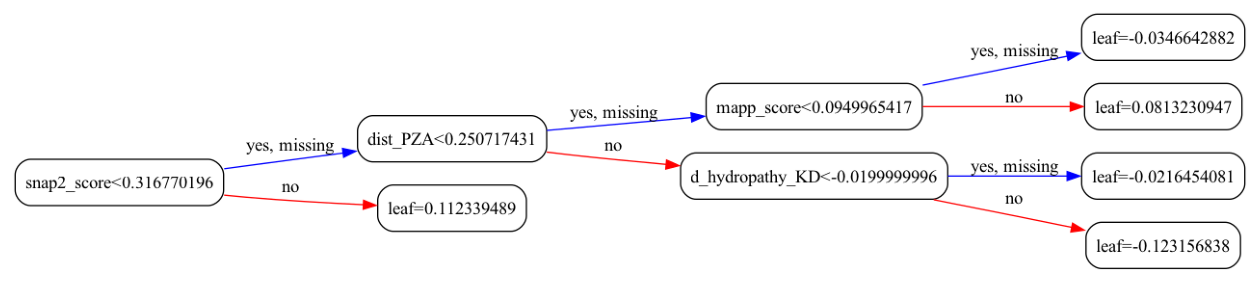

In [15]:
for i in range(9):
    fig,axes=plt.subplots(1,1,figsize=(16,16))
    xgboost.plot_tree(best_model['XB'], ax=axes, num_trees=i, rankdir='LR', condition_node_params={'shape': 'box', 'style': 'rounded'}, leaf_node_params={'shape':'box', 'style': 'rounded'})
    fig.savefig('pdf/figure-4/si-xgboost-tree-'+str(i)+'.pdf',bbox_inches='tight', transparent=True)